In [3]:
import os
import math
import random
import shutil

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [7]:
# download the data from kaggle: 
# https://www.kaggle.com/ihelon/lego-minifigures-tensorflow-tutorial
# move the folder into your project folder and create a backup of
# the star-wars images at 'lego/star-wars-images/'
BASE_DIR = 'lego/star-wars-images/'
names = ["YODA", "LUKE SKYWALKER", "R2-D2", "MACE WINDU", "GENERAL GRIEVOUS"]

tf.random.set_seed(1)

In [8]:
# Reorganize the folder structure:
if not os.path.isdir(BASE_DIR + 'train/'):
    for name in names:
        os.makedirs(BASE_DIR + 'train/' + name)
        os.makedirs(BASE_DIR + 'val/' + name)
        os.makedirs(BASE_DIR + 'test/' + name)

In [13]:
# Moce the image files
orig_folders = ["0001/", "0002/", "0003/", "0004/", "0005/"]
for folder_idx, folder in enumerate(orig_folders):
    files = os.listdir(BASE_DIR + folder)
    number_of_images = len([name for name in files])
    n_train = int((number_of_images * 0.6) + 0.5)
    n_valid = int((number_of_images*0.25) + 0.5)
    n_test = number_of_images - n_train - n_valid
    print(number_of_images, n_train, n_valid, n_test)
    for idx, file in enumerate(files):
        file_name = BASE_DIR + folder + file
        if idx < n_train:
            shutil.move(file_name, BASE_DIR + "train/" + names[folder_idx])
        elif idx < n_train + n_valid:
            shutil.move(file_name, BASE_DIR + "val/" + names[folder_idx])
        else:
            shutil.move(file_name, BASE_DIR + "test/" + names[folder_idx])

12 7 3 2
12 7 3 2
12 7 3 2
13 8 3 2
14 8 4 2


In [15]:
# Generate batches of tensor image data with
# optional real-time data augmentation.

# preprocessing_function
# rescale=1./255 -> [0,1]
train_gen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
#    rotation_range=20,
#    horizontal_flip=True,
#    width_shift_range=0.2, height_shift_range=0.2,
#    shear_range=0.2, zoom_range=0.2)

valid_gen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
test_gen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_batches = train_gen.flow_from_directory(
    'lego/star-wars-images/train',
    target_size=(256, 256),
    class_mode='sparse',
    batch_size=4,
    shuffle=True,
    color_mode="rgb",
    classes=names   
)

val_batches = valid_gen.flow_from_directory(
    'lego/star-wars-images/val',
    target_size=(256, 256),
    class_mode='sparse',
    batch_size=4,
    shuffle=False,
    color_mode="rgb",
    classes=names
)

test_batches = test_gen.flow_from_directory(
    'lego/star-wars-images/test',
    target_size=(256, 256),
    class_mode='sparse',
    batch_size=4,
    shuffle=False,
    color_mode="rgb",
    classes=names
)

Found 37 images belonging to 5 classes.
Found 16 images belonging to 5 classes.
Found 10 images belonging to 5 classes.


In [16]:
train_batch = train_batches[0]
print(train_batch[0].shape)
print(train_batch[1])
test_batch = test_batches[0]
print(test_batch[0].shape)
print(test_batch[1])

(4, 256, 256, 3)
[1. 0. 2. 0.]
(4, 256, 256, 3)
[0. 0. 1. 1.]


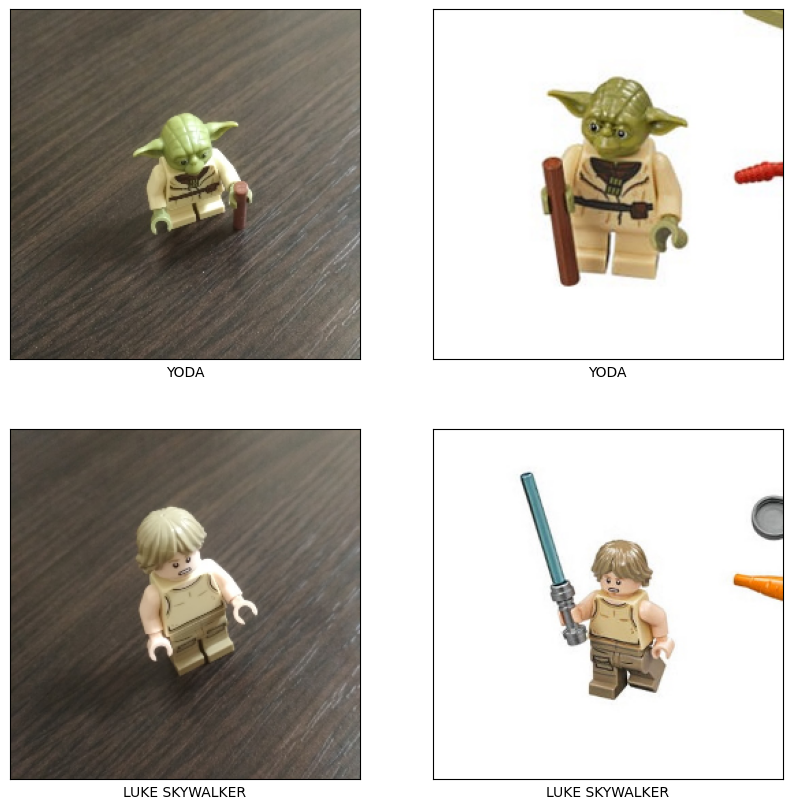

In [17]:
def show(batch, pred_labels=None):
    plt.figure(figsize=(10,10))
    for i in range(4):
        plt.subplot(2,2,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(batch[0][i], cmap=plt.cm.binary)
        # The CIFAR labels happen to be arrays, 
        # which is why you need the extra index
        lbl = names[int(batch[1][i])]
        if pred_labels is not None:
            lbl += "/ Pred:" + names[int(pred_labels[i])]
        plt.xlabel(lbl)
    plt.show()

show(test_batch)

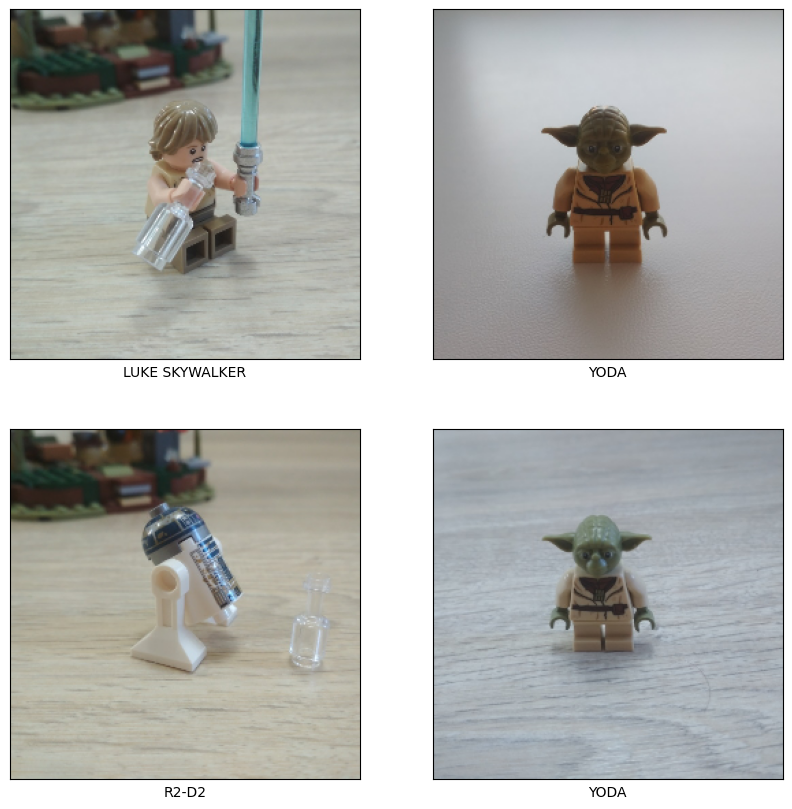

In [18]:
show(train_batch)

In [19]:
model = keras.models.Sequential()
model.add(layers.Conv2D(32, (3,3), strides=(1,1), padding="valid", activation='relu', input_shape=(256, 256,3)))
model.add(layers.MaxPool2D((2,2)))
model.add(layers.Conv2D(64, 3, activation='relu'))
model.add(layers.MaxPool2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(5))
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 246016)            0         
                                                                 
 dense (Dense)               (None, 64)                1

In [20]:
# loss and optimizer
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optim = keras.optimizers.Adam(lr=0.001)
metrics = ["accuracy"]

model.compile(optimizer=optim, loss=loss, metrics=metrics)

c:\Users\naush\.conda\envs\TensorFlowEnv\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [21]:
# training
epochs = 30

# callbacks
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    verbose=2
)

history = model.fit(train_batches, validation_data=val_batches,
                    callbacks=[early_stopping],
                      epochs=epochs, verbose=2)

Epoch 1/30
10/10 - 7s - loss: 9.7097 - accuracy: 0.2162 - val_loss: 1.6876 - val_accuracy: 0.1875 - 7s/epoch - 737ms/step
Epoch 2/30
10/10 - 3s - loss: 1.6220 - accuracy: 0.1892 - val_loss: 1.5203 - val_accuracy: 0.4375 - 3s/epoch - 340ms/step
Epoch 3/30
10/10 - 3s - loss: 1.4765 - accuracy: 0.6486 - val_loss: 1.5181 - val_accuracy: 0.5625 - 3s/epoch - 314ms/step
Epoch 4/30
10/10 - 3s - loss: 1.1795 - accuracy: 0.7027 - val_loss: 1.5507 - val_accuracy: 0.1875 - 3s/epoch - 312ms/step
Epoch 5/30
10/10 - 3s - loss: 0.8037 - accuracy: 0.7027 - val_loss: 0.8852 - val_accuracy: 0.8750 - 3s/epoch - 311ms/step
Epoch 6/30
10/10 - 3s - loss: 0.4790 - accuracy: 0.8919 - val_loss: 0.7308 - val_accuracy: 0.8750 - 3s/epoch - 301ms/step
Epoch 7/30
10/10 - 3s - loss: 0.2086 - accuracy: 0.9459 - val_loss: 0.7543 - val_accuracy: 0.6250 - 3s/epoch - 308ms/step
Epoch 8/30
10/10 - 3s - loss: 0.1186 - accuracy: 0.9730 - val_loss: 2.2013 - val_accuracy: 0.3750 - 3s/epoch - 302ms/step
Epoch 9/30
10/10 - 3s - 

In [23]:
model.save("lego_model.h5")

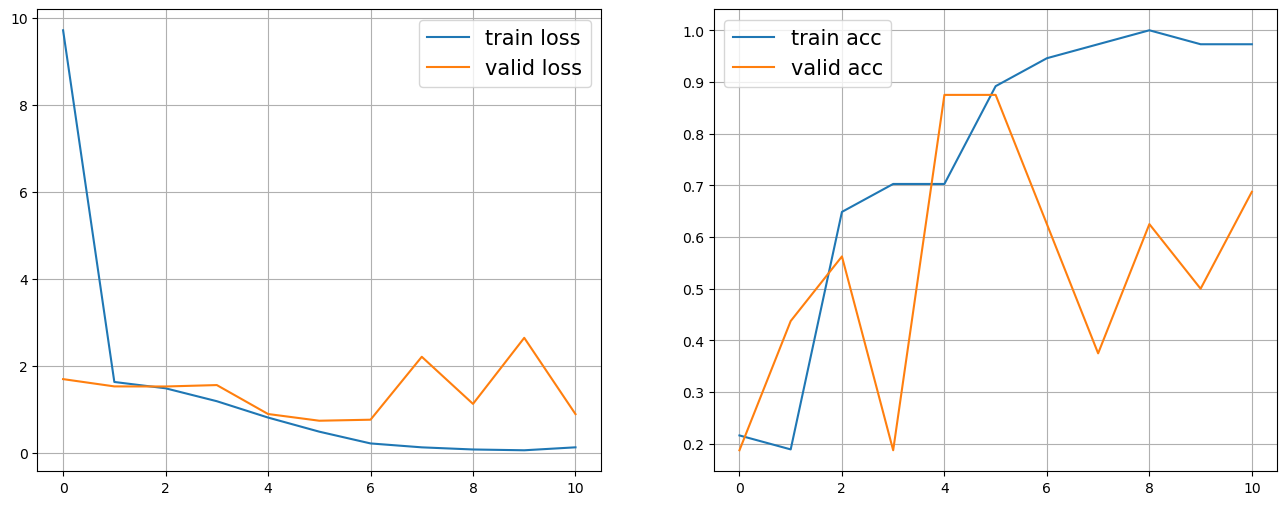

In [24]:
# plot loss and acc
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='valid loss')
plt.grid()
plt.legend(fontsize=15)

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='valid acc')
plt.grid()
plt.legend(fontsize=15);

In [25]:
# evaluate on test data
model.evaluate(test_batches, verbose=2)

3/3 - 1s - loss: 0.4572 - accuracy: 0.7000 - 554ms/epoch - 185ms/step


[0.4571826457977295, 0.699999988079071]

In [26]:
# make some predictions
predictions = model.predict(test_batches)
predictions = tf.nn.softmax(predictions)
labels = np.argmax(predictions, axis=1)

print(test_batches[0][1])
print(labels[0:4])

3/3 [==============================] - 0s 53ms/step
[0. 0. 1. 1.]
[1 1 1 3]


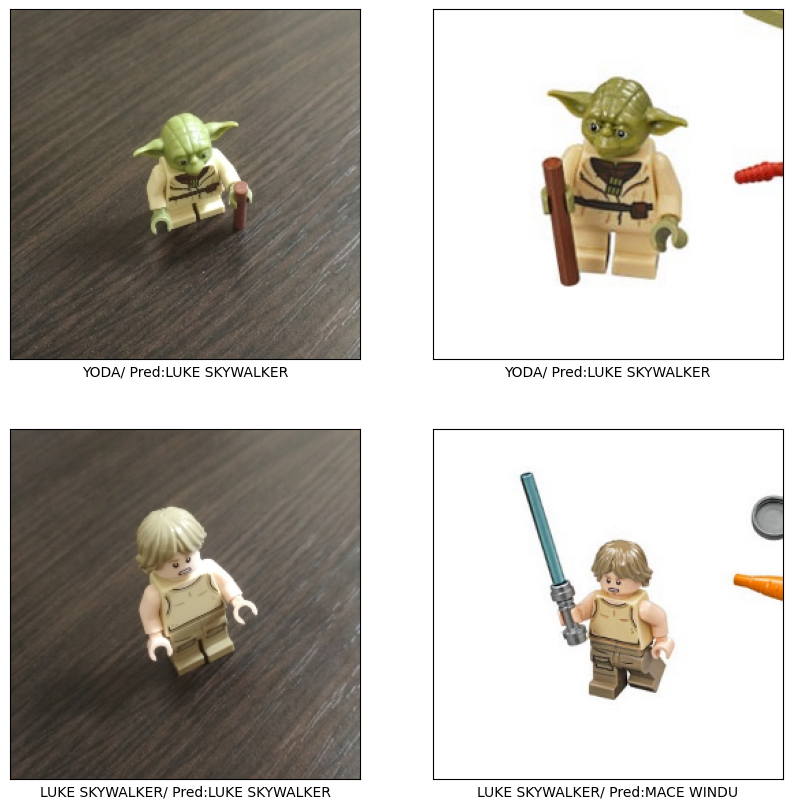

In [27]:
show(test_batches[0], labels[0:4])

# Transfer Learning

In [28]:
vgg_model = tf.keras.applications.vgg16.VGG16()
print(type(vgg_model))
vgg_model.summary()

# try out different ones, e.g. MobileNetV2
#tl_model = tf.keras.applications.MobileNetV2()
#print(type(tl_model))
#tl_model.summary()


<class 'keras.engine.functional.Functional'>
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (Ma

In [29]:
# convert to Sequential model, omit the last layer
# this works with VGG16 because the structure is linear
model = keras.models.Sequential()
for layer in vgg_model.layers[0:-1]:
    model.add(layer)

In [30]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)      

In [31]:
# set trainable=False for all layers
# we don't want to train them again
for layer in model.layers:
    layer.trainable = False
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)      

In [32]:
# add a last classification layer for our use case with 5 classes
model.add(layers.Dense(5))

In [33]:
# loss and optimizer
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optim = keras.optimizers.Adam(lr=0.001)
metrics = ["accuracy"]

model.compile(optimizer=optim, loss=loss, metrics=metrics)

In [34]:
# get the preprocessing function of this model
preprocess_input = tf.keras.applications.vgg16.preprocess_input

In [36]:
# Generate batches of tensor image data with real-time data augmentation.

train_gen = keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_input)
valid_gen = keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_input)
test_gen = keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_input)

train_batches = train_gen.flow_from_directory(
    'lego/star-wars-images/train',
    target_size=(224, 224),
    class_mode='sparse',
    batch_size=4,
    shuffle=True,
    color_mode="rgb",
    classes=names   
)

val_batches = valid_gen.flow_from_directory(
    'lego/star-wars-images/val',
    target_size=(224, 224),
    class_mode='sparse',
    batch_size=4,
    shuffle=True,
    color_mode="rgb",
    classes=names
)

test_batches = test_gen.flow_from_directory(
    'lego/star-wars-images/test',
    target_size=(224, 224),
    class_mode='sparse',
    batch_size=4,
    shuffle=False,
    color_mode="rgb",
    classes=names
)

Found 37 images belonging to 5 classes.


Found 16 images belonging to 5 classes.
Found 10 images belonging to 5 classes.


In [37]:
epochs = 30

early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    verbose=2
)

model.fit(train_batches, validation_data=val_batches,
          callbacks=[early_stopping],
          epochs=epochs, verbose=2)

Epoch 1/30
10/10 - 38s - loss: 1.8710 - accuracy: 0.4054 - val_loss: 1.0522 - val_accuracy: 0.6250 - 38s/epoch - 4s/step
Epoch 2/30
10/10 - 21s - loss: 0.3001 - accuracy: 0.8919 - val_loss: 0.7454 - val_accuracy: 0.7500 - 21s/epoch - 2s/step
Epoch 3/30
10/10 - 19s - loss: 0.0228 - accuracy: 1.0000 - val_loss: 0.5070 - val_accuracy: 0.8125 - 19s/epoch - 2s/step
Epoch 4/30
10/10 - 20s - loss: 0.0070 - accuracy: 1.0000 - val_loss: 0.4074 - val_accuracy: 0.8750 - 20s/epoch - 2s/step
Epoch 5/30
10/10 - 20s - loss: 0.0034 - accuracy: 1.0000 - val_loss: 0.3634 - val_accuracy: 0.8750 - 20s/epoch - 2s/step
Epoch 6/30
10/10 - 23s - loss: 0.0029 - accuracy: 1.0000 - val_loss: 0.3478 - val_accuracy: 0.8750 - 23s/epoch - 2s/step
Epoch 7/30
10/10 - 22s - loss: 0.0023 - accuracy: 1.0000 - val_loss: 0.3414 - val_accuracy: 0.8750 - 22s/epoch - 2s/step
Epoch 8/30
10/10 - 35s - loss: 0.0021 - accuracy: 1.0000 - val_loss: 0.3433 - val_accuracy: 0.8750 - 35s/epoch - 3s/step
Epoch 9/30
10/10 - 29s - loss: 0

In [1]:
model.evaluate(test_batches, verbose=2)

NameError: name 'model' is not defined